<a href="https://colab.research.google.com/github/mtermor/NTIC_DeepLearning/blob/WIP/Fundamentals/Preventing_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevent Overfitting: Regularization

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(0)

We will use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), consisting of a collection of 28x28 pixel images corresponding in digits from 0 to 9 manuscripts. The purpose of this data set is to train models that recognize handwritten numbers.

We will train, therefore, an [OCR (Optical Character Recognition)](https://en.wikipedia.org/wiki/Optical_character_recognition) model for multiclass classification (numbers from 0 to 9).

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train[0].shape

(28, 28)

As they are 8-bit images, the colors (in this case only one channel, the gray channel) of each pixel are encoded with a value between 0 and 255, with 0 being black and 255 being white. It is usual to normalize the values to work with a range between 0.0 and 1.0.

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0

We visualize a random image of the training set.

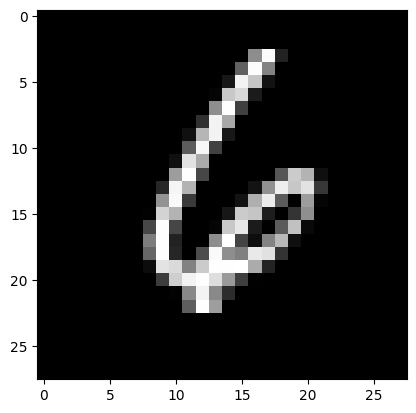

In [5]:
import numpy as np

i = np.random.randint(0, len(x_train))
plt.imshow(x_train[i], cmap='gray')
plt.show()

We reduce the dataset for  inducing more overfitting

In [6]:
# The dataset has size:
# x_train: (60000, 28, 28)
# x_test: (10000, 28, 28)
# By splitting further the train dataset, we now get x with size 2% of x_train
# x: (1200, 28, 28), where 1200 is 2% of 60000

from sklearn.model_selection import train_test_split
# split into train test sets
_, x, _, y = train_test_split(
    x_train, y_train, test_size=0.02, random_state=1, stratify=y_train)

num_classes = 10
from collections import Counter
x.shape, y.shape, Counter(y)

((1200, 28, 28),
 (1200,),
 Counter({2: 119,
          8: 117,
          6: 118,
          9: 119,
          3: 123,
          4: 117,
          0: 119,
          7: 125,
          5: 108,
          1: 135}))

#### Why do we need to use regularization?

We are going to assign the classes randomly to each image with random shuffle.

In [9]:
y_shuffle = np.copy(y)
np.random.shuffle(y_shuffle)
y[:5], y_shuffle[:5]

# assigning random values of y, it means that the images are not matched to the "correct" solution

(array([2, 8, 6, 9, 3], dtype=uint8), array([6, 4, 0, 6, 3], dtype=uint8))

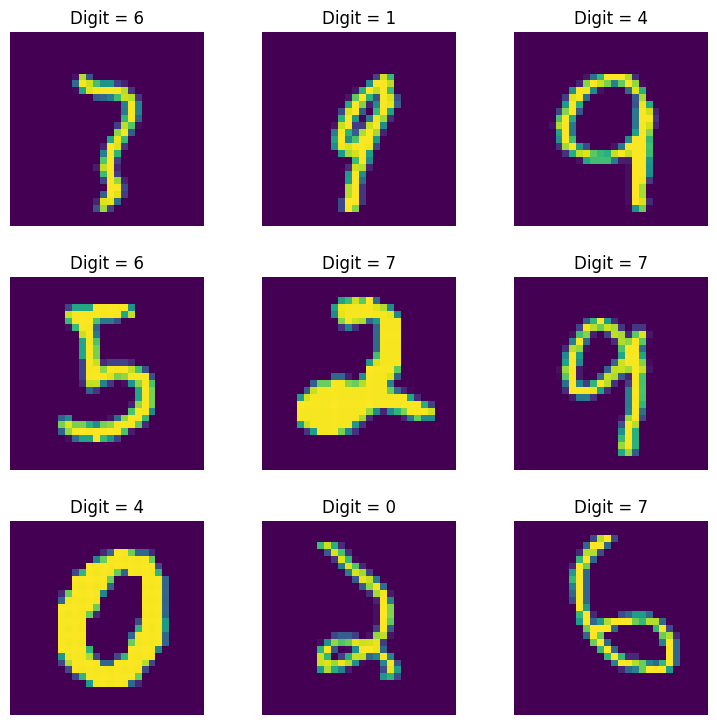

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.ravel()

for i in np.arange(0, 9):
    ind = np.random.randint(len(y_shuffle))
    axes[i].imshow(x[ind].reshape(28, 28))
    axes[i].set_title(
        f"Digit = {y_shuffle[ind]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.3)

In [11]:
# As seen, digit stored in target y is not "correct" based on the image shown

Lets build a model for learning the new random classes

In [12]:
# Input
inputs = tf.keras.Input(shape=(28, 28))

# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(64, activation='relu')(flat)
# hidden layer 2
l_2 = layers.Dense(64, activation='relu')(l_1)
# hidden layer 3
l_3 = layers.Dense(64, activation='relu')(l_2)

# Outputs
outputs = layers.Dense(10, activation='softmax')(l_3)

# Model definition
model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
flat.shape #TensorShape([None, 784])
# Each image is composed of 28x28 pixels that form an image. Hence, when flattened,
# we have 784 "pieces of information" which have been converted to a vector

TensorShape([None, 784])

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    x,
    y_shuffle,
    batch_size=64,
    epochs=100,
    shuffle=True
)

Epoch 1/100
19/19 [==============================] - 2s 4ms/step - loss: 2.3106 - accuracy: 0.0958
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 2.2771 - accuracy: 0.1567
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 2.2495 - accuracy: 0.1842
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 2.2048 - accuracy: 0.2275
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 2.1604 - accuracy: 0.2375
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 2.0981 - accuracy: 0.2667
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 2.0339 - accuracy: 0.3042
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9644 - accuracy: 0.3433
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 1.8720 - accuracy: 0.3683
Epoch 10/100
19/19 [==============================] - 0s 5ms/step - loss: 1.7792 - accuracy: 0.3967
Epoch 11/

In [17]:
results = model.evaluate(x, y_shuffle, verbose=0)
print('Train Accuracy: {}'.format(results[1]))

Train Accuracy: 1.0


In [18]:
# Train accuracy of 1! Even if wrongly assigned, the model learns to "wrongly" assing these

1/1 [==============================] - 0s 31ms/step


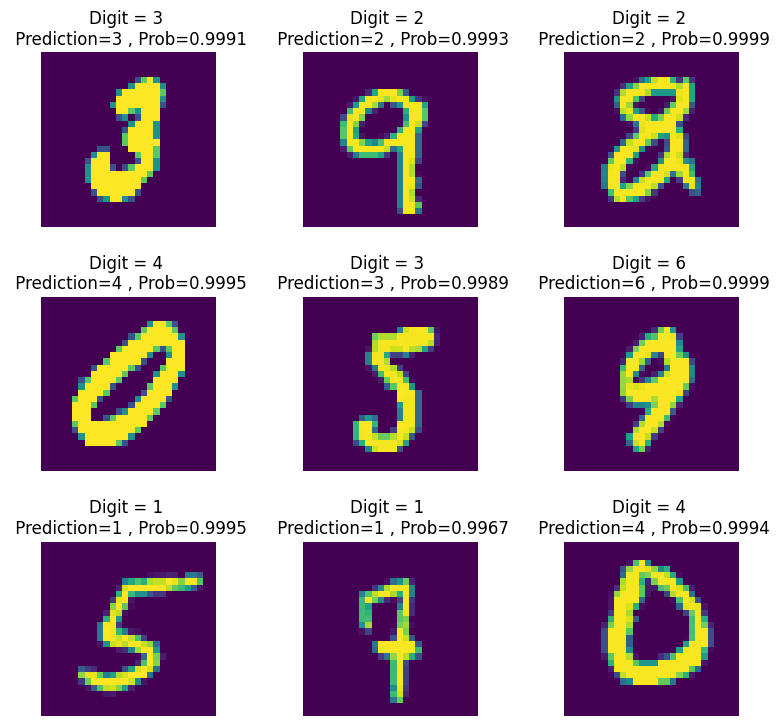

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.ravel()

for i in np.arange(0, 9):
    ind = np.random.randint(len(y_shuffle))
    pred_pobs = model.predict(np.expand_dims(x[ind], 0)).flatten()
    pred_class = np.argmax(pred_pobs)
    prob = np.max(pred_pobs)
    axes[i].imshow(x[ind].reshape(28, 28))
    axes[i].set_title(
        f"Digit = {y_shuffle[ind]} \n Prediction={pred_class} , Prob={prob:.4f}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)


We can see that the model has fully fitted the training set. It practically does not matter what data you introduce into the neural network, it will almost always fit. The objective is not to fit the training set, it is to **GENERALIZE**.

#### Regularization for preventing overfitting

To get the model to **generalize**, we can use one of the numerous regularization techniques

We build a model consisting of:

- Input with dimension (28,28)
- Flatten layer
- Dense hidden  layer with 256 neurons and ReLU as activation function
- Second dense hidden layer with 128 neurons and ReLU as activation function
- Third dense  hidden layer with 128 neurons and ReLU as activation function
- Output layer with a single neuron that implements the sigmoid function.

In [21]:
# Input
inputs = tf.keras.Input(shape=(28, 28), name='input_layer')

# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(256, activation='relu')(flat)
# hidden layer 2
l_2 = layers.Dense(128, activation='relu')(l_1)
# hidden layer 3
l_3 = layers.Dense(128, activation='relu')(l_2)

# Outputs - with num_classes and softmax activation
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(l_3)

# Model definition
model = keras.Model(inputs=inputs, outputs=outputs, name='dont_overfit_model')
model.summary()

Model: "dont_overfit_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               200960    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 251658 (983.04 KB)
Trainable param

We define the following configuration for training:
- **optimizer**: adam
- **loss function**: binary crossentropy
- **metrics**: accuracy

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# Model fit with x and y (reduced set taken as 2% of train set before)
history = model.fit(
    x,
    y,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/100
15/15 [==============================] - 2s 30ms/step - loss: 1.8296 - accuracy: 0.4990 - val_loss: 1.1294 - val_accuracy: 0.7375
Epoch 2/100
15/15 [==============================] - 0s 9ms/step - loss: 0.7285 - accuracy: 0.8135 - val_loss: 0.5297 - val_accuracy: 0.8375
Epoch 3/100
15/15 [==============================] - 0s 10ms/step - loss: 0.4010 - accuracy: 0.8760 - val_loss: 0.4259 - val_accuracy: 0.8708
Epoch 4/100
15/15 [==============================] - 0s 10ms/step - loss: 0.2307 - accuracy: 0.9302 - val_loss: 0.3566 - val_accuracy: 0.9083
Epoch 5/100
15/15 [==============================] - 0s 9ms/step - loss: 0.1405 - accuracy: 0.9740 - val_loss: 0.3201 - val_accuracy: 0.9083
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 0.1058 - accuracy: 0.9760 - val_loss: 0.4272 - val_accuracy: 0.9000
Epoch 7/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0834 - accuracy: 0.9833 - val_loss: 0.3856 - val_accuracy: 0.8917
Epoch 8/1

In [24]:
results = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5542672276496887
Test Accuracy: 0.9083999991416931


We visualize the evolution of the values in each epoch of the loss function and accuracy.

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,1.829616,0.498958,1.129440,0.737500,0
1,0.728474,0.813542,0.529680,0.837500,1
2,0.401010,0.876042,0.425936,0.870833,2
3,0.230680,0.930208,0.356605,0.908333,3
4,0.140467,0.973958,0.320093,0.908333,4


<a id='overfitting_results'></a>
When interpreting both graphs, it is evident that the model over-fits the training values and is not able to generalize well for the validation values. **It is a clear example of overfitting**.

The following function will be useful throughout the different practical examples.

In [26]:
import matplotlib.pyplot as plt

def show_loss_accuracy_evolution(history):

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

def show_samples(x_test, y_test, model):
    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, -1)

    L = 5
    W = 5
    fig, axes = plt.subplots(L, W, figsize=(14, 14))
    axes = axes.ravel()

    for i in np.arange(0, L * W):
        ind = np.random.randint(len(y_test))
        axes[i].imshow(x_test[ind].reshape(28, 28))
        prob_pred = np.max(predictions[ind, :])
        class_pred = int(predicted_classes[ind])
        original_class = int(y_test[ind])
        if class_pred == original_class:
            color = 'green'
        else:
            color = 'red'
        title = "Pred: {0} \n Target: {1} \n Prob: {2:.3f}".format(
        class_pred, original_class, prob_pred)
        axes[i].set_title(title, color=color)
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)

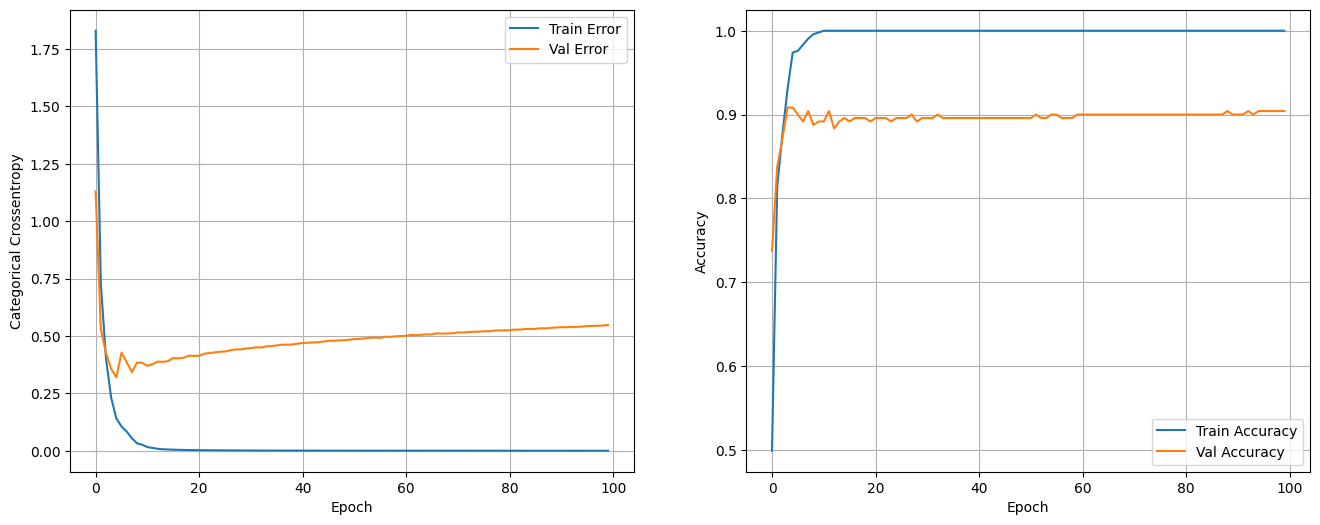

In [27]:
show_loss_accuracy_evolution(history)

In [28]:
results = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5542672276496887
Test Accuracy: 0.9083999991416931


313/313 [==============================] - 2s 5ms/step


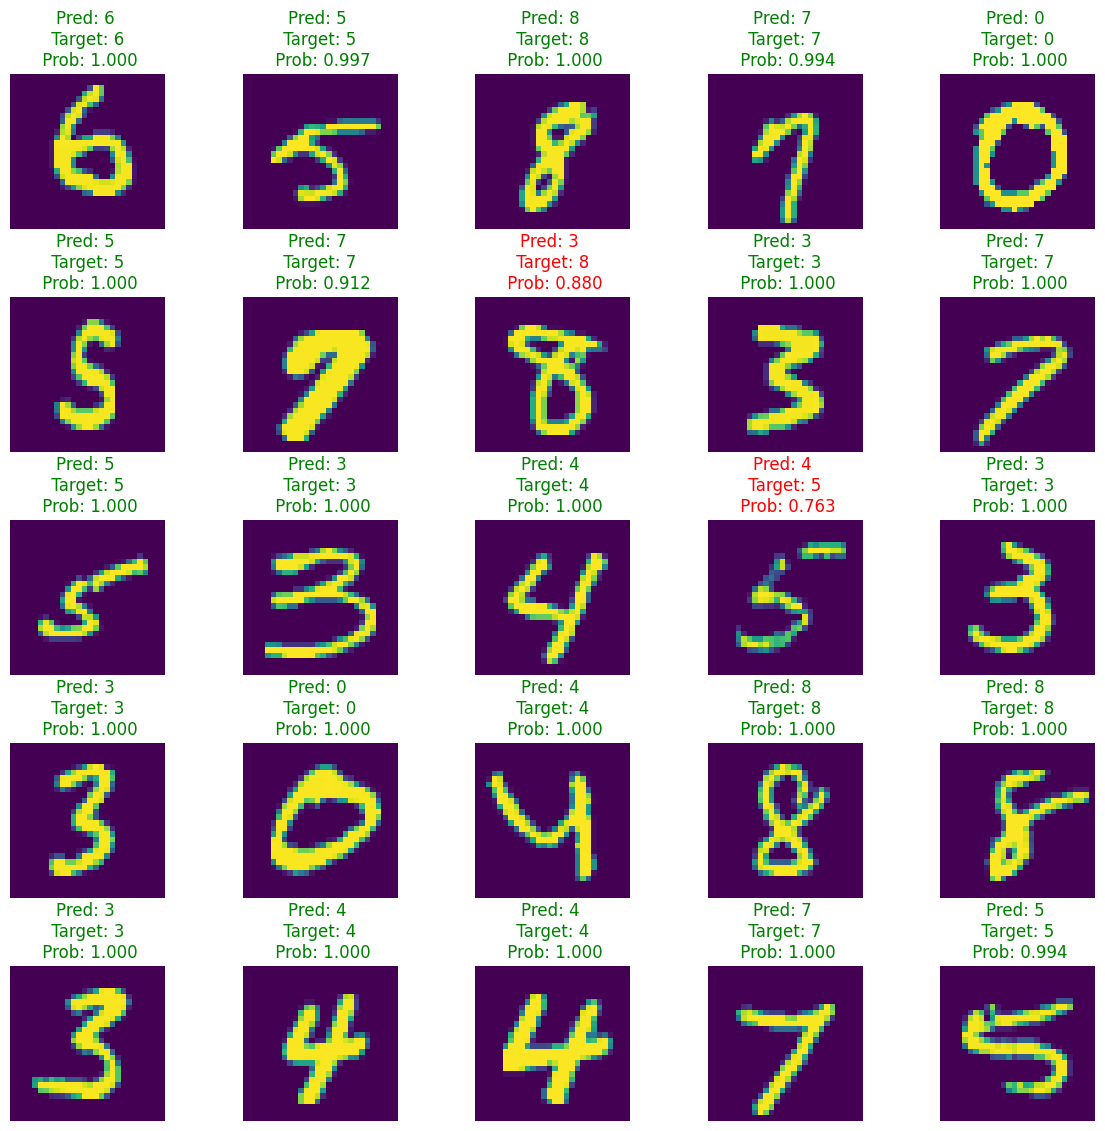

In [29]:
show_samples(x_test, y_test, model)

## Create a simpler model

The simplest way to prevent overfitting is to create  a simple model: A model with less number of  parameters (which is determined by the number of layers and the number of units per layer).

A more complex model with more parameters will have much more capacity and will be able to learn almost any training set. Deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

In [30]:
# Input layer
inputs = tf.keras.Input(shape=(28, 28), name='input_layer')
flat = layers.Flatten()(inputs)

# First hidden layer
l_1 = layers.Dense(8, activation='relu', name='layer_1')(flat)

# Output layer
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(l_1)
model_simpler = keras.Model(inputs=inputs, outputs=outputs, name='simpler_model')

model_simpler.summary()

Model: "simpler_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 layer_1 (Dense)             (None, 8)                 6280      
                                                                 
 output_layer (Dense)        (None, 10)                90        
                                                                 
Total params: 6370 (24.88 KB)
Trainable params: 6370 (24.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
model_simpler.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
history_simpler = model_simpler.fit(x,
                                    y,
                                    batch_size=64,
                                    epochs=100,
                                    validation_split=0.25,
                                    shuffle=True)

Epoch 1/100
15/15 [==============================] - 2s 22ms/step - loss: 2.2714 - accuracy: 0.1478 - val_loss: 2.1797 - val_accuracy: 0.2433
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 2.1113 - accuracy: 0.2644 - val_loss: 2.0247 - val_accuracy: 0.3000
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 1.9638 - accuracy: 0.3300 - val_loss: 1.8972 - val_accuracy: 0.4133
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 1.8188 - accuracy: 0.4178 - val_loss: 1.7797 - val_accuracy: 0.4700
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 1.6944 - accuracy: 0.4778 - val_loss: 1.6802 - val_accuracy: 0.5467
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 1.5813 - accuracy: 0.5756 - val_loss: 1.6011 - val_accuracy: 0.5833
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 1.4695 - accuracy: 0.6111 - val_loss: 1.5060 - val_accuracy: 0.6233
Epoch 8/100


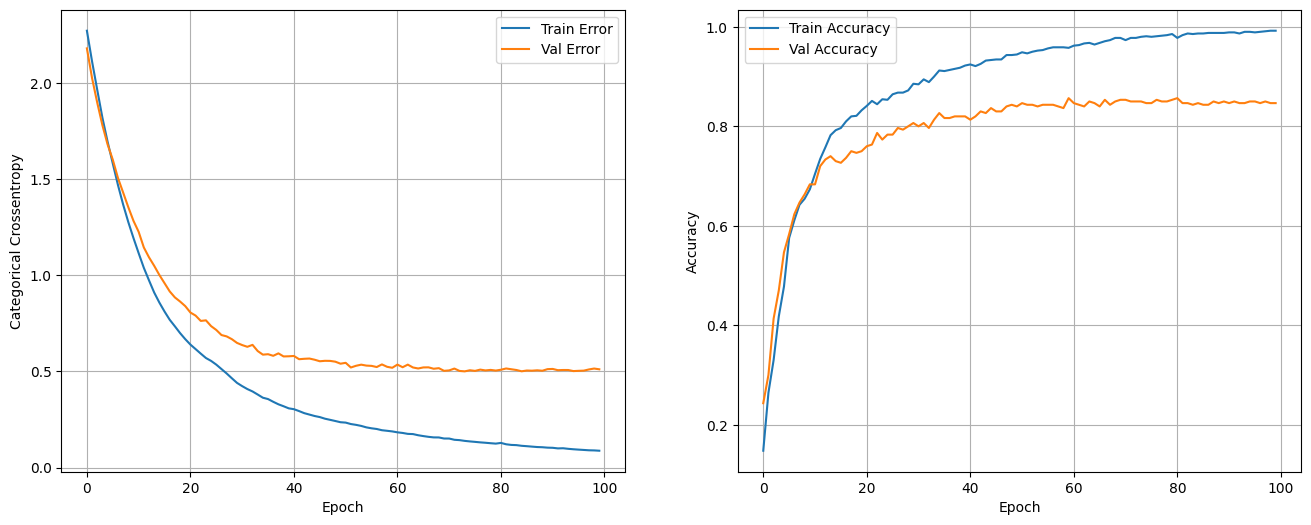

In [32]:
show_loss_accuracy_evolution(history_simpler)

In [33]:
# Loss error - there is almost "no overfitting" here, as the error does not increase
# although the train error starts tending to 0.
# Accuracy - train takes a lot longer to reach one than in the previous model, implying
# the model is not learning as fast but can be more generalised, as shown by the val
# accuracy parameter. Although test accuracy is lower than in the previous model, the
# model can be considered more generalised.

In [34]:
results = model_simpler.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5765352249145508
Test Accuracy: 0.8432999849319458


## Reduce batch_size

Other method is decreasing the `batch_size`during the gradient descend to add more uncertainty to the estimation of the parameter gradients, thus reducing the capacity of the model

In [35]:
# Input
inputs = tf.keras.Input(shape=(28,28), name='input_layer')

# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(256, activation='relu', name='layer_1')(flat)
# hidden layer 2
l_2 = layers.Dense(128, activation='relu', name='layer_2')(l_1)
# hidden layer 3
l_3 = layers.Dense(128, activation='relu', name='layer_3')(l_2)

# Outputs
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(l_3)

# Model definition
model = keras.Model(inputs=inputs, outputs=outputs, name='dont_overfit_model')
## same model
model.summary()

Model: "dont_overfit_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 layer_1 (Dense)             (None, 256)               200960    
                                                                 
 layer_2 (Dense)             (None, 128)               32896     
                                                                 
 layer_3 (Dense)             (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 251658 (983.04 KB)
Trainable param

In [36]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_2 = model.fit(
    x,
    y,
    batch_size=16, # reduced from 64 before
    epochs=100,
    validation_split=0.2,
    shuffle=True
)


Epoch 1/100
60/60 [==============================] - 2s 17ms/step - loss: 1.1932 - accuracy: 0.6458 - val_loss: 0.5042 - val_accuracy: 0.8208
Epoch 2/100
60/60 [==============================] - 1s 11ms/step - loss: 0.3663 - accuracy: 0.8875 - val_loss: 0.4188 - val_accuracy: 0.8667
Epoch 3/100
60/60 [==============================] - 1s 10ms/step - loss: 0.2396 - accuracy: 0.9198 - val_loss: 0.4513 - val_accuracy: 0.8792
Epoch 4/100
60/60 [==============================] - 1s 10ms/step - loss: 0.1247 - accuracy: 0.9667 - val_loss: 0.3651 - val_accuracy: 0.8875
Epoch 5/100
60/60 [==============================] - 1s 10ms/step - loss: 0.0727 - accuracy: 0.9802 - val_loss: 0.3848 - val_accuracy: 0.8917
Epoch 6/100
60/60 [==============================] - 1s 12ms/step - loss: 0.0349 - accuracy: 0.9917 - val_loss: 0.4086 - val_accuracy: 0.8875
Epoch 7/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0217 - accuracy: 0.9958 - val_loss: 0.3747 - val_accuracy: 0.9042
Epoch 

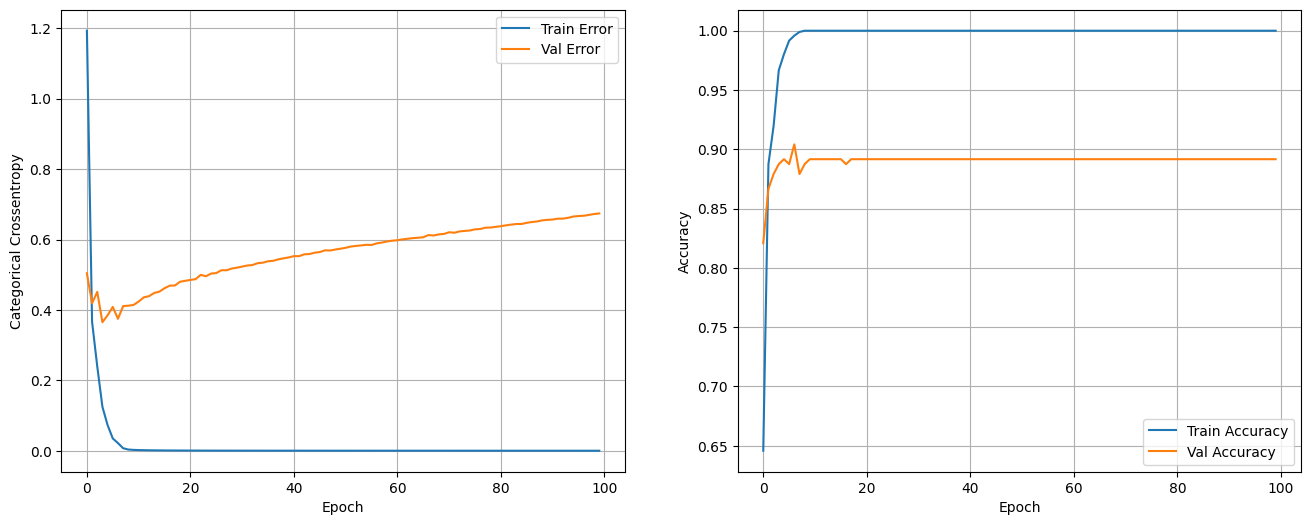

In [37]:
show_loss_accuracy_evolution(history_2)

In [39]:
results = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6600618362426758
Test Accuracy: 0.9104999899864197


### Question 1:
#### What differences do you see if you change the batch_size to a lower or higher value? For example to 1 and to 512

In [38]:
# batch_size: Number of samples per batch of computation.

# For 1 then it is taking a look at just one random value - will take a long time to find the "right path"
# For 512 then the model is taking almost half of the samples to find the "lowest point". It will take longer
# but will converge faster

<a id='dropout'></a>
## Dropout

Dropout, applied to a layer, consists of randomly "dropping out" (set to zero) a number of output features of the layer during training with a probability **p** (`dropout rate`).

In `keras` you can introduce dropout in a network via the [Dropout layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), which gets applied to the output of layer right before.

```python
tf.keras.layers.Dropout(
    rate, noise_shape=None, seed=None, **kwargs
)
```

With Functional API:
```python
next_layer = layers.Dropout(0.4)(prev_layer)
```
With Sequential:
```python
model.add(layers.Dropout(0.4))
```